# Classification: Predicting Diabetes Based on Modifiable Factors

(max 2000 written words, not including citations)

# Introduction

Our project investigates potential key factors associated with diabetes mellitus in females of Pima Indian descent aged 21 and above. Diabetes mellitus is a serious disease affecting many populations causing severe health complications such as heart failure, with the main associated cause of death being coronary heart disease (Das, 2014). Those of Indian descent often have higher rates of diabetes suggesting a potential genetic predisposition to insulin resistance, however many other factors can play a role in the presence of diabetes. There are many known risk factors associated with this disorder, some of which include parental diabetes, obesity, and genetic components (Das, 2014). High rates of diabetes mellitus is not only a severe health issue, but it also places a significant strain on the healthcare system (Krishnamoorthy et al., 2022). Throughout our project we aim to answer the question of whether the 5 factors we have selected can accurately predict the onset of diabetes within a five year time frame with a high degree of over 75%. The original data set consisted of 9 different attributes, however we have chosen to narrow our scope to focus on the five factors most associated with potential modifiable or reversible qualities. The observations we will be examining throughout our project include plasma glucose concentration level at 2 hours in an oral glucose tolerance test (ie. glucose test, mg/dl), diastolic blood pressure (mmHg), triceps skin fold thickness (a measure of body fat (mm)), hour serum insulin (µU/mL), and body mass index (kg/m^2). The data set we have chosen is titled “Diabetes Dataset” created from the findings of the National Institute of Diabetes and Digestive and Kidney Diseases which was uploaded by Mehmet Akturk found on Kaggle.




- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

**Research question:**
Can the 5 following modifiable/reversible factors predict the onset of diabetes within 5 years with a high degree of accuracy (>75%)?
1. Plasma glucose concentration level at 2 hours in an oral glucose tolerance test (ie. glucose test, mg/dl)
2. Diastolic blood pressure (mmHg)
3. Triceps skin fold thickness - a measure of body fat (mm)
4. 2-Hour serum insulin (µU/mL)
5. Body mass index (kg/m^2)



# Methods

Our classifier was trained to predict diabetes development in the next 5 years (ie. pre-diabetes, Outcome) using K-nearest neighbors analysis. First, all non-modifiable/irreversible variables were filtered out from our dataset. The filtered dataset was split into training (75% of the data) and testing (25% of the data) sets. The training set was used for exploratory analysis of the dataset: the mean of each variable in the non-diabetic and pre-diabetic was calculated, and the distributions of each variable were visualized. To select the appropriate value of K (number of neighbors) for our classifier, the training data was split into 10 subsets for cross-validation, and the cross-validation sets were used to tune the model. The accuracy estimates from K = [0,100] were visualized, and the optimal accuracy estimate was chosen at K = 21 for the classifier. The classifier was subsequently trained using the chosen K, with all the variables in the filtered dataset selected as parameters for classification of impending diabetes development (Outcome). The classifier was evaluated on the testing set, and the resulting predictions were compared to the actual outcome in the study as a confusion matrix. Accuracy, precision, and recall of the classifier were all calculated to evaluate the quality of classifier predictions.

- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis. - mention packages

# Analysis

- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs the data analysis

## Diabetes Dataset

Our dataset was obtained from Kaggle at the following URL: 

https://www.kaggle.com/datasets/mathchi/diabetes-data-set?fbclid=IwAR1DMzdJFDxoEqLDIZNTi3j7YJXTx_7BJwCl7sbn8syQKbQCnHfMtlsKH1E

This dataset was uploaded by user Mehmet Akturk and was sourced from the National Institute of Diabetes and Digestive and Kidney Diseases (donated by RMI Group Leader Vincent Sigillito).

The study population consisted of 768 female patients of at least 21 years of age and Pima Indian heritage, living near Phoenix, Arizona, USA. Researchers collected the following data:
 1. Number of times pregnant
 2. Plasma glucose concentration level at 2 hours in an oral glucose tolerance test (ie. glucose test, mg/dl)
 3. Diastolic blood pressure (mmHg)
 4. Triceps skin fold thickness - a measure of body fat (mm)
 5. 2-Hour serum insulin (µU/mL)
 6. Body mass index (kg/m^2)
 7. Diabetes pedigree function (probability of diabetes based on family history) 
 8. Age
 9. Outcome (0 = glucose test negative for diabetes 5+ years after data collection, 1 = glucose test positive for diabetes within 5 years of data collection)

Diabetes was diagnosed by a plasma glucose concentration level greater than 200 mg/dl at 2 hours in an oral glucose tolerance test. All patients had a negative glucose test for diabetes at initial data collection. 

## Importing and Tidying Data

Ensure that the following packages are installed before proceeding:

In [1]:
# installation packages commented out for convenience.
#install.packages("tidyverse")
#install.packages("tidymodels")
#install.packages("gridExtra")
#install.packages("repr")
#install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Set seed and load necessary packages.

In [62]:
# set seed and load necessary packages

set.seed(1000)

library("rlang")
library("tidyverse")
library("gridExtra")
library("repr")
library("kknn")
library("tidymodels")

In [63]:
install.packages('gridExtra')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Read in "diabetes.csv" from the DSCI_100_Diabetes_Prediction repository on GitHub.

In [64]:
# read in data

diabetes_dataset <- read_csv("https://raw.githubusercontent.com/hesoru/DSCI_100_Diabetes_Prediction/main/Dataset/diabetes.csv")

head(diabetes_dataset)
dim(diabetes_dataset)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


[1] 768   9

We will remove irreversible or non-modifiable variables from our classifier: pregnancies (not a reversible variable), diabetes pedigree function (probability of diabetes based on family history, not modifiable), and age.

The dataset has no N/A values, however some cells have a value equal to 0. Glucose, blood pressure, skin thickness, insulin, and BMI cannot have a reading of 0 in practice. Cells with value of 0 in these columns will be treated as N/A and filtered out.

In [65]:
diabetes_dataset_filtered <- diabetes_dataset |>
    select(-Pregnancies, -DiabetesPedigreeFunction, -Age) |>
    filter(Glucose != 0, BloodPressure != 0, SkinThickness != 0, Insulin != 0, BMI != 0)

head(diabetes_dataset_filtered)
dim(diabetes_dataset_filtered)

Glucose,BloodPressure,SkinThickness,Insulin,BMI,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89,66,23,94,28.1,0
137,40,35,168,43.1,1
78,50,32,88,31.0,1
197,70,45,543,30.5,1
189,60,23,846,30.1,1
166,72,19,175,25.8,1


[1] 392   6

Note that we have filtered out approximately half of the patients in our dataset, with a final sample size of n = 392.

## Splitting Data into Training and Testing Sets

Now that our data is tidy, we will split our data into training (75% of the data) and testing (25% of the data) sets, and convert the categorical variable Outcome into the factor data type.

In [68]:
diabetes_dataset_filtered_split <- initial_split(data = diabetes_dataset_filtered,
                                                 prop = 0.75,
                                                 strata = Outcome)
training_filtered <- training(diabetes_dataset_filtered_split) |>
    mutate(Outcome = as_factor(Outcome))
testing_filtered <- testing(diabetes_dataset_filtered_split) |>
    mutate(Outcome = as_factor(Outcome))

head(training_filtered)
dim(training_filtered)

head(testing_filtered)
dim(testing_filtered)

Glucose,BloodPressure,SkinThickness,Insulin,BMI,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
89,66,23,94,28.1,0
103,30,38,83,43.3,0
126,88,41,235,39.3,0
97,66,15,140,23.2,0
145,82,19,110,22.2,0
88,58,11,54,24.8,0


[1] 293   6

Glucose,BloodPressure,SkinThickness,Insulin,BMI,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
189,60,23,846,30.1,1
158,76,36,245,31.6,1
111,72,47,207,37.1,1
171,110,24,240,45.4,1
103,80,11,82,19.4,0
150,66,42,342,34.7,0


[1] 99  6

## Exploration of Training Data

In [70]:
patient_means_by_outcome <- training_filtered |>
    group_by(Outcome) |>
    summarise(Patients = n(),
              Mean_Glucose = mean(Glucose),
              Mean_BP = mean(BloodPressure),
              Mean_SkinThickness = mean(SkinThickness),
              Mean_Insulin = mean(Insulin),
              Mean_BMI = mean(BMI))
patient_means_by_outcome

Outcome,Patients,Mean_Glucose,Mean_BP,Mean_SkinThickness,Mean_Insulin,Mean_BMI
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,196,110.6071,68.91837,26.29592,130.9031,31.60816
1,97,143.5876,74.35052,32.92784,192.7423,35.99794


- 0 = negative glucose test for diabetes 5 years after data collection
- 1 = positive glucose test for diabetes within 5 years of data collection

**Interpretation:**
- 97/293 patients received a positive glucose test for diabetes (1) within 5 years of data collection. This implies a startling rate of diabetes development, however it is possible that some patients were already diabetic at data collection (false negatives).
- There is a large relative difference (at least 25%) in Mean_Glucose and Mean_Insulin between pre-diabetics and non-diabetics.

In [71]:
options(repr.plot.width = 10, repr.plot.height = 7)

patient_distribution_glucose <- training_filtered |>
    ggplot(aes(x = Glucose)) +
    geom_histogram(bins = 10, binwidth = 5, aes(fill=Outcome)) +
    labs(x = "Glucose Plasma Concentration (mg/dl)",
         y = "Number of Patients") +
    theme(text = element_text(size = 10)) +
    theme(legend.position = "none")

patient_distribution_BP <- training_filtered |>
    ggplot(aes(x = BloodPressure)) +
    geom_histogram(bins = 10, binwidth = 4, aes(fill=Outcome)) +
    labs(x = "Diastolic Blood Pressure (mmHg)",
         y = "Number of Patients") +
    theme(text = element_text(size = 10)) +
    theme(legend.position = "none")

patient_distribution_SkinThickness <- training_filtered |>
    ggplot(aes(x = SkinThickness)) +
    geom_histogram(bins = 10, binwidth = 2, aes(fill=Outcome)) +
    labs(x = "Tricep Skin Thickness (mm)",
         y = "Number of Patients") +
    theme(text = element_text(size = 10)) +
    theme(legend.position = "none")

patient_distribution_Insulin <- training_filtered |>
    ggplot(aes(x = Insulin)) +
    geom_histogram(bins = 10, binwidth = 25, aes(fill=Outcome)) +
    labs(x = "2-Hour Serum Insulin (µU/mL)",
         y = "Number of Patients") +
    theme(text = element_text(size = 10)) +
    theme(legend.position = "none")

patient_distribution_BMI <- training_filtered |>
    ggplot(aes(x = BMI)) +
    geom_histogram(bins = 10, binwidth = 2, aes(fill=Outcome)) +
    labs(x = "Body Mass Index (kg/m^2)",
         y = "Number of Patients") +
    scale_fill_discrete(labels=c('Non-Diabetic', 'Pre-Diabetic')) +
    theme(text = element_text(size = 10)) 
    

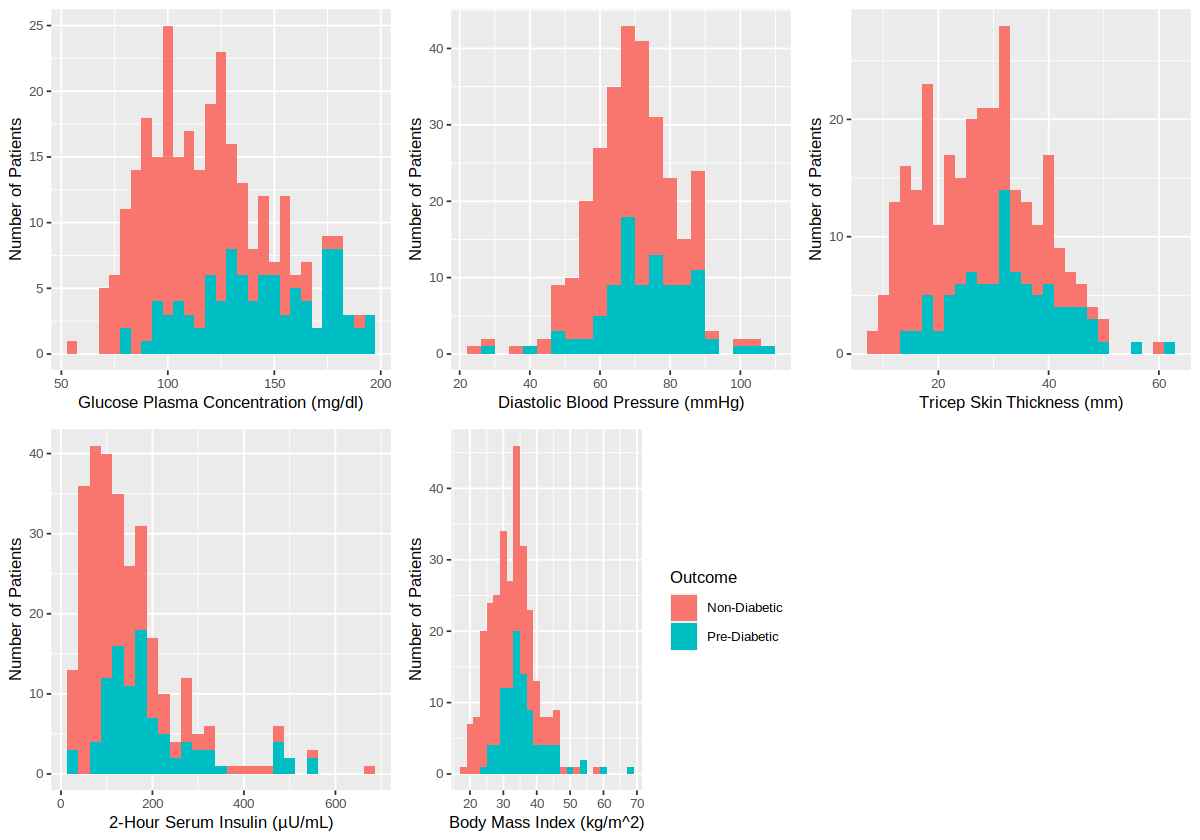

In [72]:
grid.arrange(patient_distribution_glucose,
             patient_distribution_BP,
             patient_distribution_SkinThickness,
             patient_distribution_Insulin,
             patient_distribution_BMI,
             ncol=3)

**Normal ranges (cite source)**
- Glucose plasma concentration: < 140 mg/dl
- Diastolic BP: < 80 mmHg
- Tricep skin thickness: 23.6 ± 7.5 mm
- 2-hour Serum Insulin: 16-166 uU/mL
- BMI: 18.5 to 24.9

**Interpretation:**
- Glucose plasma concentration is a normal distribution skewed to the left: the long tail to the right implies diabetics with abnormal blood glucose
- Diastolic BP is a normal distribution centered around 70 mmHg, with a small subset to the right with diastolic hypertension 
- ...
- BMI is a normal distribution centered around 35 kg/m^2, which falls into the obese range


## Selecting K for the Classifier

First we will set up the model recipe, specifications, split the training data into 10 subsets for cross-validation, and set the k values to test.

In [73]:
set.seed(1000)

knn_recipe <- recipe(Outcome ~ ., data = training_filtered) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold <- vfold_cv(training_filtered, v = 10, strata = Outcome)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

In [74]:
knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = vfold, grid = k_vals) |>
  collect_metrics() 
                 
accuracies <- knn_results |>
    filter(.metric =="accuracy")
accuracies 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7000328,10,0.01184848,Preprocessor1_Model01
6,accuracy,binary,0.6901560,10,0.01626682,Preprocessor1_Model02
11,accuracy,binary,0.6895649,10,0.01486776,Preprocessor1_Model03
16,accuracy,binary,0.7063465,10,0.01427872,Preprocessor1_Model04
21,accuracy,binary,0.7202709,10,0.01135484,Preprocessor1_Model05
26,accuracy,binary,0.7201478,10,0.01716950,Preprocessor1_Model06
31,accuracy,binary,0.7269376,10,0.02148399,Preprocessor1_Model07
36,accuracy,binary,0.7232430,10,0.02101931,Preprocessor1_Model08
41,accuracy,binary,0.7136043,10,0.02198184,Preprocessor1_Model09


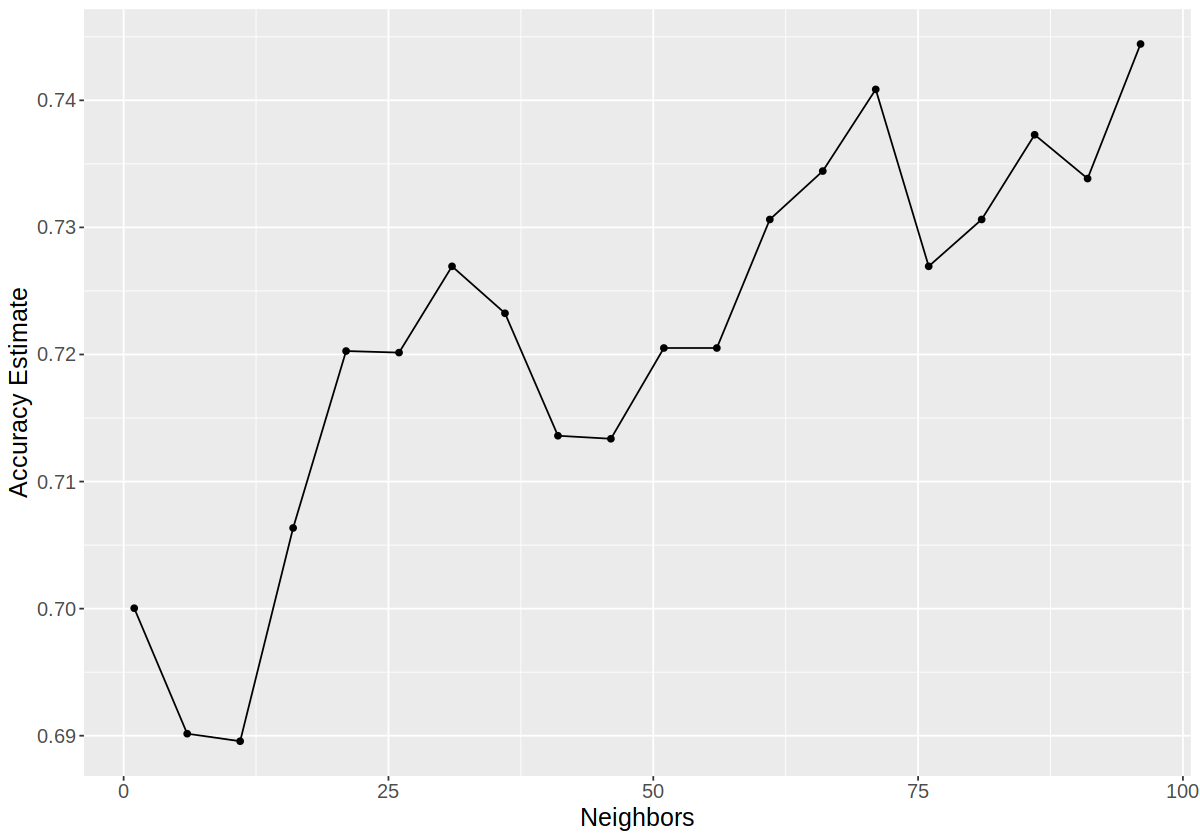

In [76]:
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 15))

cross_val_plot

Setting the number of neighbors to K = 21 provides the highest estimated accuracy, thus we will move forward using this K-value for the classification.

## Training the Classifier

Now we will combine our recipe, KNN specification (with a new K), and training data to train our model.

In [77]:
set.seed(1000)

# our knn_recipe was defined previously when tuning the classifier

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |> 
    set_engine("kknn") |>
    set_mode("classification")

mnist_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(mnist_spec) |>
    fit(data = training_filtered)

## Evaluating the Classifier's Performance

We will build a confusion matrix based off our classifier's labelling.

In [78]:
set.seed(1000)

mnist_predictions <- predict(mnist_fit, testing_filtered) |>
    bind_cols(testing_filtered)
mnist_predictions

mnist_metrics <- mnist_predictions |>
    metrics(truth = Outcome, estimate = .pred_class) |>
    filter(.metric == "accuracy")
mnist_metrics

mnist_conf_mat <- mnist_predictions |>
    conf_mat(truth = Outcome, estimate = .pred_class)

mnist_conf_mat

.pred_class,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Outcome
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,189,60,23,846,30.1,1
1,158,76,36,245,31.6,1
0,111,72,47,207,37.1,1
1,171,110,24,240,45.4,1
0,103,80,11,82,19.4,0
0,150,66,42,342,34.7,0
0,141,58,34,128,25.4,0
0,95,66,13,38,19.6,0
0,81,78,40,48,46.7,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7878788


          Truth
Prediction  0  1
         0 60 15
         1  6 18

## $ \textrm{accuracy} = \frac{\textrm{number of correct predictions}}{\textrm{total number of predictions}} = \frac{\textrm{61 + 14}}{\textrm{61 + 19 + 5 + 14}} = 0.7576 $

## $ \textrm{precision} = \frac{\textrm{number of correct positive predictions}}{\textrm{total number of positive predictions}} = \frac{\textrm{14}}{\textrm{14 + 5}} = 0.7368 $

## $ \textrm{recall} = \frac{\textrm{number of correct positive predictions}}{\textrm{total number of positive test set predictions}} = \frac{\textrm{14}}{\textrm{14 + 19}} = 0.4242 $

Our primary objective is to identify pre-diabetic patients among the Pima Indian population, with the goal of initiating lifestyle modifications to hopefully prevent the onset of diabetes.

The accuracy of our classifier is quite high, identifying whether or not patients are pre-diabetic 75.76% of the time. However, our classifier is less reliable with correctly identifying pre-diabetics, identifying just 42.42% of pre-diabetic patients. Though the recall of this classifier needs to be improved, it is still an improvement on the current medical system, which does not tend to identify *any* pre-diabetic patients.

There are minimal consequences to the classifier labeling a false-negative result (19.19%), as pre-diabetic patients that are missed do not yet require treatment. There are also minimal consequences to the classifier labeling a false-positive result (5.051%), as any patient would benefit from the lifestyle modifications that prevent the onset of diabetes.

# Results

In [79]:
conf_mat_table <- data.frame(T_or_F = c("True", "False", "True", "False"),
                             Neg_or_Pos = c("Negative (Non-Diabetic)", "Negative (Non-Diabetic)",
                                            "Positive (Pre-Diabetic)", "Positive (Pre-Diabetic)"),
                             Value = c(61, 19, 14, 5)) |>
                             mutate(Proportion = Value/99)

conf_mat_table

T_or_F,Neg_or_Pos,Value,Proportion
<chr>,<chr>,<dbl>,<dbl>
True,Negative (Non-Diabetic),61,0.61616162
False,Negative (Non-Diabetic),19,0.19191919
True,Positive (Pre-Diabetic),14,0.14141414
False,Positive (Pre-Diabetic),5,0.05050505


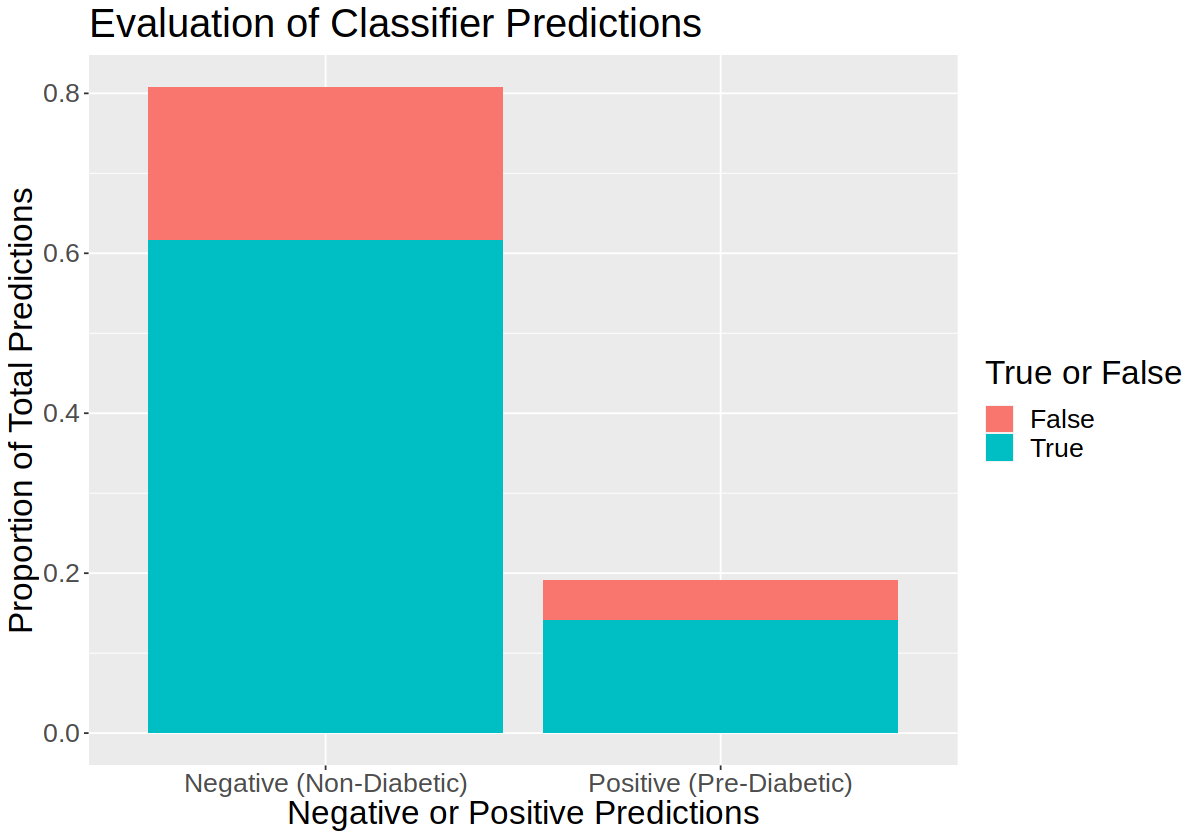

In [80]:
mnist_plot <- ggplot(conf_mat_table, aes(x = Neg_or_Pos, y = Proportion, fill = T_or_F)) +
       geom_bar(stat = "identity") +
       labs(x = "Negative or Positive Predictions",
            y = "Proportion of Total Predictions",
            fill = "True or False") + 
       ggtitle("Evaluation of Classifier Predictions") +
       theme(text = element_text(size = 20))
mnist_plot

- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- creates a visualization of the analysis 
- note: all tables and figure should have a figure/table number and a legend

# Discussion

This study has found that a k-nearest-neighbor classification algorithm trained on the 5 selected predictors: glucose plasma concentration, diastolic blood pressure, triceps skin thickness, 2-hour serum insulin and body mass index, can achieve a relatively high (>75%) accuracy on classifying pre-diabetic patients, as early as 5 years before diagnostic.

This finding is expected. It was clear in the data exploration that there exists an observable difference in the selected predictors between non-diabetic and pre-diabetic patients. Although the statistical significance of these differences was not tested for, it was hypothesized that such differences are enough to facilitate a classification algorithm. 

The relatively high accuracy is also supported by a number of past studies which suggested an individual correlation between the selected predictors and diabetes. Edeoga et al. suggested a positive correlation between blood glucose and blood pressure, and blood pressure was successfully used to predict pre-diabetic patients among initially normoglycemic samples. Mbanya et al. also agrees with this correlation by mentioning high blood pressure as a "major driver" of diabetes. Skin thickness can be used to predict body fat percentage, and the accuracy of such method has been confirmed (Jayawardena et al., 2020). Body fat percentage can then be used as a predictor of diabetes. Singh et al. and Nassr et al. have suggested a high practicality of this method. Although both of the studies focused primarily on gestational diabetes, the correlation between body fat percentage and diabetes is apparent. Similarly, high levels of fasting insulin and true insulin are strongly associated with pre-diabetes(Quan et al., 2021); He et al. suggested that body mass index is a predictor of whether a pre-diabetes patient converts to diabetes.

The findings of this study combine the results of past studies in a practical case. These correlations are further confirmed and the effectiveness of these predictors combined is investigated. Unlike diabetes which is incurable at the time of writing, pre-diabetic patients can be saved from converting to diabetes if the correct treatment can be given in time. This study examined the knn-classification methods for diagnosing pre-diabetes, which can potentially be used to provide valuable extra time for pre-diabetic patients to be treated and to adapt to a different lifestyle. Furthermore, this study also reveals some possible limitations in practical usage, which can be the direction of further studies: despite the overall accuracy being acceptable, the recall of this algorithm is low. Depending on the actual requirements which differ between scenarios, a low recall can lead to patients who need to be treated or warned being neglected. Unfortunately, this study does not intend to further optimize this algorithm, leaving it as a future topic.

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

# References

(APA style)

- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.

Das, R. N. (2014). Determinants of diabetes mellitus in the Pima Indian mothers and Indian Medical Students. The Open Diabetes Journal, 7(1), 5–13. https://doi.org/10.2174/1876524601407010005

Edeoga, C., Owei, I., Siwakoti, K., Umekwe, N., Ceesay, F., Wan, J., &amp; Dagogo-Jack, S. (2017). Relationships between blood pressure and blood glucose among offspring of parents with type 2 diabetes: Prediction of incident dysglycemia in a biracial cohort. Journal of Diabetes and Its Complications, 31(11), 1580–1586. https://doi.org/10.1016/j.jdiacomp.2017.07.019 

He, Y., Feng, Y., Shi, J., Tang, H., Chen, L., &amp; Lou, Q. (2022). Β‐cell function and body mass index are predictors of exercise response in elderly patients with Prediabetes. Journal of Diabetes Investigation, 13(7), 1253–1261. https://doi.org/10.1111/jdi.13777 

Jayawardena, R., Waniganayake, Y. C., Abhayaratna, S. A., &amp; Ranasinghe, P. (2020). Prediction of body fat in Sri Lankan adults: Development and validation of a skinfold thickness equation. Diabetes &amp;amp; Metabolic Syndrome: Clinical Research &amp;amp; Reviews, 14(2), 147–150. https://doi.org/10.1016/j.dsx.2020.02.003 

Krishnamoorthy, Y., Rajaa, S., Verma, M., Kakkar, R., & Kalra, S. (2022). Spatial patterns and determinants of diabetes mellitus in Indian adult population: A secondary data analysis from nationally representative surveys. Diabetes Therapy, 14(1), 63–75. https://doi.org/10.1007/s13300-022-01329-6

Mbanya, V. N., Mbanya, J., Kufe, C., &amp; Kengne, A. P. (2016). Effects of single and multiple blood pressure measurement strategies on&nbsp;the prediction of prevalent screen‐detected diabetes mellitus: A&nbsp;population‐based survey. The Journal of Clinical Hypertension, 18(9), 864–870. https://doi.org/10.1111/jch.12774 

Nassr, A. A., Shazly, S. A., Trinidad, M. C., El-Nashar, S. A., Marroquin, A. M., &amp; Brost, B. C. (2018). Body fat index: A novel alternative to body mass index for prediction of gestational diabetes and hypertensive disorders in pregnancy. European Journal of Obstetrics &amp;amp; Gynecology and Reproductive Biology, 228, 243–248. https://doi.org/10.1016/j.ejogrb.2018.07.001 

Quan, H., Fang, T., Lin, L., Lin, L., Ou, Q., Zhang, H., Chen, K., &amp; Zhou, Z. (2021). Effects of fasting proinsulin/fasting insulin, proinsulin/insulin, vitamin D3, and waistline on diabetes prediction among the Chinese Han population. International Journal of Diabetes in Developing Countries, 42(2), 218–226. https://doi.org/10.1007/s13410-021-00983-z 

Singh, D., Mittal, P., Bachani, S., Mukherjee, B., Mittal, M. K., &amp; Suri, J. (2023). Ultrasonographic assessment of body fat index for prediction of gestational diabetes mellitus and neonatal complications. Journal of Obstetrics and Gynaecology Canada, 45(11), 102177. https://doi.org/10.1016/j.jogc.2023.04.026 